# Tanaka function
---
**Description**:

- Optimization (min, max)
- Multi-objective (2)
- Constraints (2)
---

The equations are given by:

\begin{cases}
      f_{1}\left(\mathbf{x}\right) = x, \text{ needs to maximize} \\
      f_{2}\left(\mathbf{x}\right) = y, \text{ needs to minimize} \\
\end{cases}

subject to:

\begin{cases}
      C_{1}\left(\mathbf{x}\right) = x^{2} + y^{2} - 1 - 0.1\cos\left(16 \arctan(x/y) \right) \geq 0, \\
      C_{2}\left(\mathbf{x}\right) = \left(x - 0.5\right)^{2} + \left(y - 0.5\right)^{2} \leq 0.5 \\
\end{cases}

where $0\le x \le \pi$ and $0\le y \le \pi$.

The constrained Pareto-optimal solutions lie on the boundary of the first constraint. Since the constraint function is periodic

and the second constraint function must also be satisfied, not all solutions on the boundary of the first constraint are Pareto-optimal. 

## Step 1: Import python libraries and set up the project directory

In [25]:
import os, sys
import numpy as np
from math import fsum
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')

if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

## Step 2: Import the custom PSO code

In [26]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import pareto_front, cost_function

## Step 3: Define the multi-objective function

In [27]:
@cost_function(minimize=True)
def fun_tanaka(vector_xy: np.ndarray, **kwargs) -> float:

    # Extract the current iteration.
    it = kwargs["it"]
    
    # Set the penalty coefficient.
    rho = 50.0
    
    # Extract the values from the particle position.
    x, y = vector_xy
    
    # Avoid "division by zero" errors.
    if y == 0.0:
        y = 1.0e-8
    # _end_if_
    
    # Compute each objective function.
    f1, f2 = x, y

    # Compute the constraints.
    C1 = min(0.0, x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)))**2
    C2 = max(0.0, (x - 0.5)**2 + (y - 0.5)**2 - 0.5)**2

    # Assign the weights.
    w1 = (it % 50) / 50
    w2 = 1.0 - w1

    # Compute the final value.
    f_value = fsum([w1*f1, w2*f2, rho*(C1 + C2)])

    # Return the solution.
    return f_value
# _end_def_

## Step 4: Set the PSO parameters

    - Number of particles 'N'
    - Initial population
    - PSO object

In [28]:
# Set a seed for reproducible initial population.
SEED = 1821

# Random number generator.
rng = np.random.default_rng(SEED)

# Define the number of optimizing variables.
D = 2

# Define the number of particles.
N = 50

# Draw random samples for the initial points.
X_t0 = rng.uniform(0.0, np.pi, size=(N, D))

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in X_t0])

# Create a StandardPSO object that will perform the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0,
                       obj_func = fun_tanaka,
                       x_min = 0.0, x_max = np.pi)

## Step 5: Run the optimization process

In [29]:
test_PSO.run(max_it = 500,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "g_best"},
             reset_swarm = False, verbose = False, adapt_params = False)

12/18/2025 10:15:55 INFO: Initial f_optimal = -0.1735


Final f_optimal = -0.9159
run: elapsed time = 0.382 seconds.


## Step 6: Extract the data for analysis and plotting

In [30]:
# Get the optimal solution from the PSO.
i_opt, _, x_opt = test_PSO.get_optimal_values()

# Extract optimal f-values.
f1_opt, f2_opt = x_opt

# Display the (final) optimal values.
print(f"Optimum Found: {f1_opt, f2_opt}\n")

# Display each gene value separately.
for i, xi in enumerate(x_opt, start=1):
    print(f"x{i} = {xi:>10.6f}")
# _end_for_

Optimum Found: (np.float64(1.0392085514519769), np.float64(0.03492681220182092))

x1 =   1.039209
x2 =   0.034927


### Compute the Pareto front

In [31]:
# Create a list that will hold points that satisfy both constraints.
points = []

# Generate grid sample on [0, pi].
for x in np.linspace(0.0, np.pi, 125):
    
    for y in np.linspace(0.0, np.pi, 125):
        
        # Avoid "division by zero" errors.
        if y == 0.0:
            y = 1.0e-8
        # _end_if_

        # Compute the constraints.
        C1 = x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)) >= 0.0
        C2 = (x - 0.5)**2 + (y - 0.5)**2 <= 0.5

        # If both constraints are satisfied.
        if C1 and C2:

            # Evaluate both functions.
            f1, f2 = x, y

            # Keep the point in the list.
            points.append((f1, f2))
        # _end_if_
    # _end_if_
# _end_for_

# Convert lists to numpy.
points = np.array(points)

# Estimate the pareto front points.
pareto_points = pareto_front(points)

### Visualize the solution on the Pareto plot

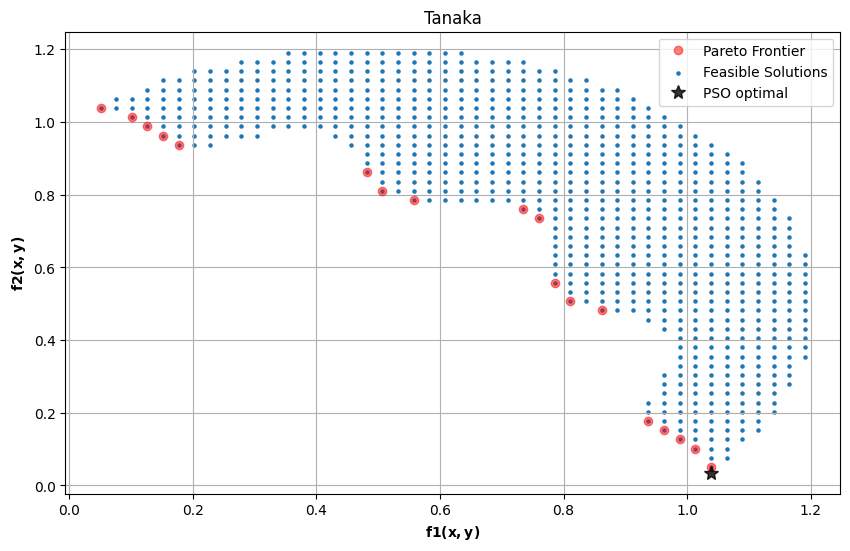

In [32]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.plot(pareto_points[:, 0],
         pareto_points[:, 1],
         'ro', alpha=0.5, label="Pareto Frontier")

# Plot all the feasible solutions.
plt.scatter(x=points[:, 0],
            y=points[:, 1],
            s=5, marker='o', label="Feasible Solutions")

# Plot the optimal solution from the PSO.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="PSO optimal")

# Tidy up the plot.
plt.title("Tanaka")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Tanaka_optimal.pdf", format="pdf", dpi=300)

### End of file